# A Recommender system from Netflix movies and series Database

### Based on embedding similarity as it can account for the text's semantic relationship and contextual meaning to get accurate recommendations based on the input of a User.

In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data1 = pd.read_csv("netflix_movies_detailed_up_to_2025.csv")
data2 =pd.read_csv("netflix_tv_shows_detailed_up_to_2025.csv")

In [4]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   show_id       16000 non-null  int64  
 1   type          16000 non-null  object 
 2   title         16000 non-null  object 
 3   director      15868 non-null  object 
 4   cast          15796 non-null  object 
 5   country       15534 non-null  object 
 6   date_added    16000 non-null  object 
 7   release_year  16000 non-null  int64  
 8   rating        16000 non-null  float64
 9   duration      0 non-null      float64
 10  genres        15893 non-null  object 
 11  language      16000 non-null  object 
 12  description   15868 non-null  object 
 13  popularity    16000 non-null  float64
 14  vote_count    16000 non-null  int64  
 15  vote_average  16000 non-null  float64
 16  budget        16000 non-null  int64  
 17  revenue       16000 non-null  int64  
dtypes: float64(4), int64(5), o

- ## Combine them into one complete dataset

In [5]:
# Combine them into one complete dataset
data = pd.concat([data1, data2], ignore_index=True)

In [6]:
data

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,genres,language,description,popularity,vote_count,vote_average,budget,revenue
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010-05-16,2010,6.380,NaN,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,165000000.0,752600867.0
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010-07-15,2010,8.369,NaN,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,160000000.0,839030630.0
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010-11-17,2010,7.744,NaN,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,250000000.0,954305868.0
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010-11-24,2010,7.600,NaN,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600,260000000.0,592461732.0
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010-03-18,2010,7.800,NaN,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800,165000000.0,494879471.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,284892,TV Show,Sammelanam,NaN,NaN,NaN,2025-02-20,2025,0.000,1 Seasons,"Comedy, Drama",te,Sammelanam is a gripping Telugu web series tha...,3.236,0,0.000,NaN,NaN
31996,277665,TV Show,Anne Shirley,NaN,"Honoka Inoue, Yasunori Matsumoto, Aya Nakamura...",Japan,2025-04-05,2025,0.000,1 Seasons,"Animation, Drama, Family",ja,It's depict Anne's growth from a girl to a wom...,3.558,0,0.000,NaN,NaN
31997,284972,TV Show,Le onde del passato,Giulio Manfredonia,"Anna Valle, Giorgio Marchesi, Irene Ferri, Fau...",NaN,2025-02-19,2025,10.000,1 Seasons,Drama,it,NaN,2.913,1,10.000,NaN,NaN
31998,284613,TV Show,AI히치하이커,NaN,NaN,NaN,2025-02-16,2025,0.000,1 Seasons,NaN,ko,NaN,2.787,0,0.000,NaN,NaN


- ## Removing unncessary columns

In [7]:
data.drop(['date_added','budget','revenue', 'duration'],axis = 1, inplace = True)

In [8]:
data

,show_id,type,title,director,cast,country,release_year,rating,genres,language,description,popularity,vote_count,vote_average
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010,6.380,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010,8.369,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010,7.744,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010,7.600,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010,7.800,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31995,284892,TV Show,Sammelanam,NaN,NaN,NaN,2025,0.000,"Comedy, Drama",te,Sammelanam is a gripping Telugu web series tha...,3.236,0,0.000
31996,277665,TV Show,Anne Shirley,NaN,"Honoka Inoue, Yasunori Matsumoto, Aya Nakamura...",Japan,2025,0.000,"Animation, Drama, Family",ja,It's depict Anne's growth from a girl to a wom...,3.558,0,0.000
31997,284972,TV Show,Le onde del passato,Giulio Manfredonia,"Anna Valle, Giorgio Marchesi, Irene Ferri, Fau...",NaN,2025,10.000,Drama,it,NaN,2.913,1,10.000
31998,284613,TV Show,AI히치하이커,NaN,NaN,NaN,2025,0.000,NaN,ko,NaN,2.787,0,0.000


In [9]:
data['language'].unique()

array(['en', 'es', 'sr', 'pt', 'ko', 'fr', 'hi', 'ja', 'th', 'no', 'de',
       'zh', 'it', 'fi', 'cn', 'sv', 'is', 'ta', 'nl', 'da', 'ru', 'tr',
       'el', 'te', 'bn', 'ar', 'ca', 'fa', 'ro', 'he', 'cs', 'hu', 'pl',
       'ml', 'ms', 'id', 'ku', 'xx', 'tl', 'gl', 'lt', 'si', 'et', 'hr',
       'ps', 'mi', 'uk', 'af', 'km', 'mr', 'sk', 'kn', 'eu', 'lv', 'la',
       'dz', 'kk', 'mk', 'ka', 'vi', 'mn', 'pa', 'ga', 'yo', 'zu', 'ky',
       'ur', 'kl', 'ht', 'am', 'ne', 'hy', 'sl', 'bg', 'lb', 'bs', 'as',
       'cy', 'nb', 'za', 'or', 'az', 'mt'], dtype=object)

In [10]:
# Mapping the language codes to their full language names
language_map = {
    'en': 'English', 'es': 'Spanish', 'sr': 'Serbian', 'pt': 'Portuguese', 'ko': 'Korean', 
    'fr': 'French', 'hi': 'Hindi', 'ja': 'Japanese', 'th': 'Thai', 'no': 'Norwegian', 
    'de': 'German', 'zh': 'Chinese', 'it': 'Italian', 'fi': 'Finnish', 'cn': 'Chinese', 
    'sv': 'Swedish', 'is': 'Icelandic', 'ta': 'Tamil', 'nl': 'Dutch', 'da': 'Danish', 
    'ru': 'Russian', 'tr': 'Turkish', 'el': 'Greek', 'te': 'Telugu', 'bn': 'Bengali', 
    'ar': 'Arabic', 'ca': 'Catalan', 'fa': 'Persian', 'ro': 'Romanian', 'he': 'Hebrew', 
    'cs': 'Czech', 'hu': 'Hungarian', 'pl': 'Polish', 'ml': 'Malayalam', 'ms': 'Malay', 
    'id': 'Indonesian', 'ku': 'Kurdish', 'xx': 'Unknown', 'tl': 'Tagalog', 'gl': 'Galician', 
    'lt': 'Lithuanian', 'si': 'Sinhala', 'et': 'Estonian', 'hr': 'Croatian', 'ps': 'Pashto', 
    'mi': 'Maori', 'uk': 'Ukrainian', 'af': 'Afrikaans', 'km': 'Khmer', 'mr': 'Marathi', 
    'sk': 'Slovak', 'kn': 'Kannada', 'eu': 'Basque', 'lv': 'Latvian', 'la': 'Latin', 
    'dz': 'Dzongkha', 'kk': 'Kazakh', 'mk': 'Macedonian', 'ka': 'Georgian', 'vi': 'Vietnamese', 
    'mn': 'Mongolian', 'pa': 'Punjabi', 'ga': 'Irish', 'yo': 'Yoruba', 'zu': 'Zulu', 
    'ky': 'Kyrgyz', 'ur': 'Urdu', 'kl': 'Greenlandic', 'ht': 'Haitian Creole', 'am': 'Amharic', 
    'ne': 'Nepali', 'hy': 'Armenian', 'sl': 'Slovenian', 'bg': 'Bulgarian', 'lb': 'Luxembourgish', 
    'bs': 'Bosnian', 'as': 'Assamese', 'cy': 'Welsh', 'nb': 'Norwegian Bokmål', 'za': 'Zhuang', 
    'or': 'Odia', 'az': 'Azerbaijani', 'mt': 'Maltese'
}

In [11]:
data['language_full'] = data['language'].map(language_map)


# Exploratory Data Analysis

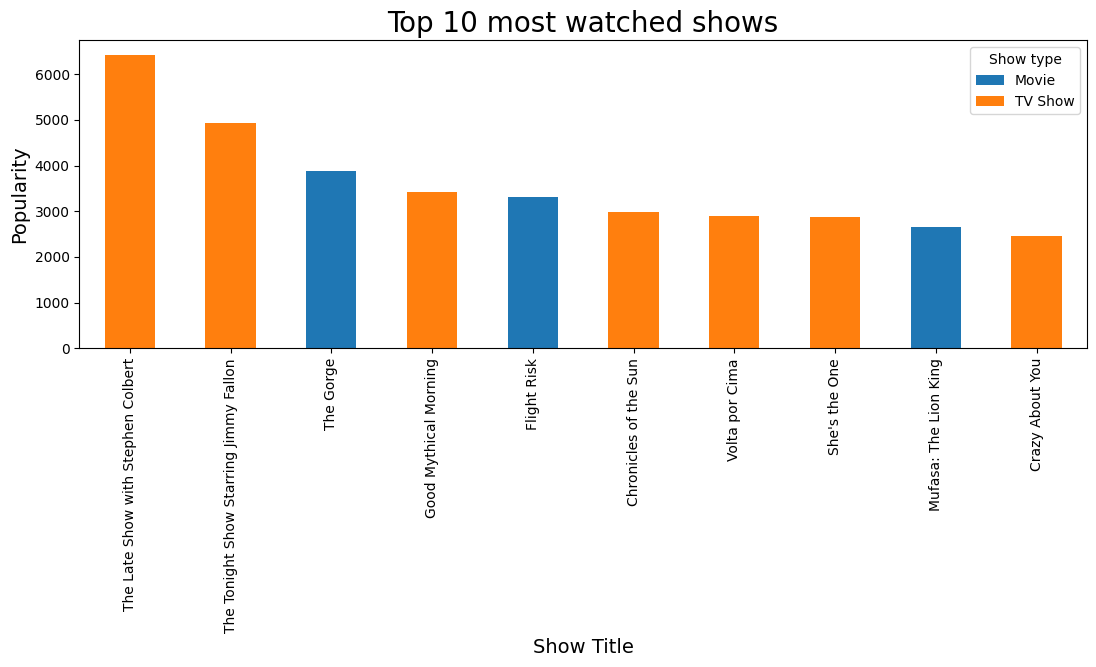

In [12]:
# Top 10 most watched shows
sum1 = data.groupby(['title', 'type'])['popularity'].sum().nlargest(10).unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(13, 4))

sum1.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Top 10 most watched shows', fontsize=20)
ax.set_xlabel('Show Title', fontsize=14)
ax.set_ylabel('Popularity', fontsize=14)
ax.tick_params(axis='x', rotation=90)
ax.legend(title='Show type')

plt.show()


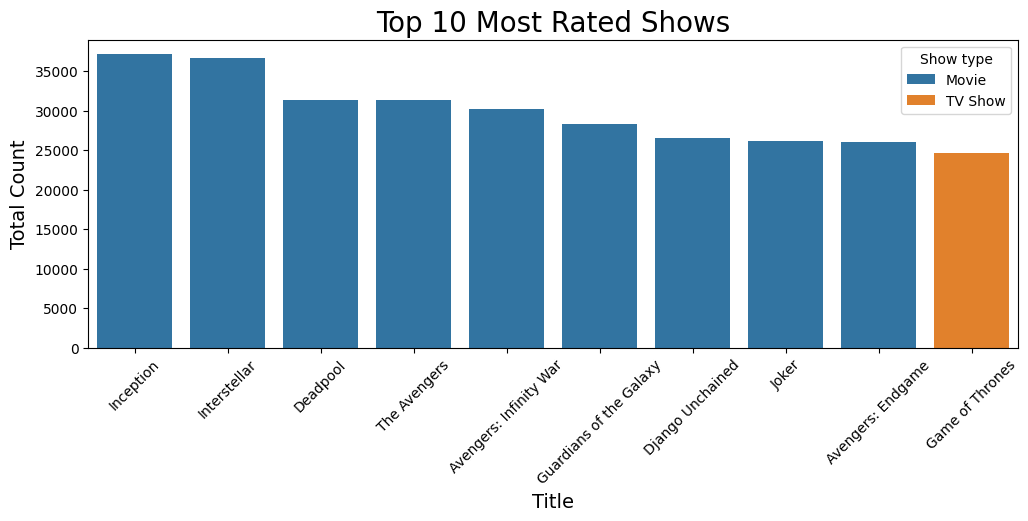

In [13]:
plt.figure(figsize = (12,4))
sns.barplot(x='title', y = 'vote_count', hue = 'type', data = data.sort_values('vote_count', ascending = False) .head(10))
plt.title('Top 10 Most Rated Shows', fontsize = 20)
plt.xlabel('Title', fontsize = 14)
plt.ylabel("Total Count", fontsize =14)
plt.xticks(rotation = 45)
plt.legend(title = 'Show type')
plt.show()

<Figure size 1300x700 with 0 Axes>

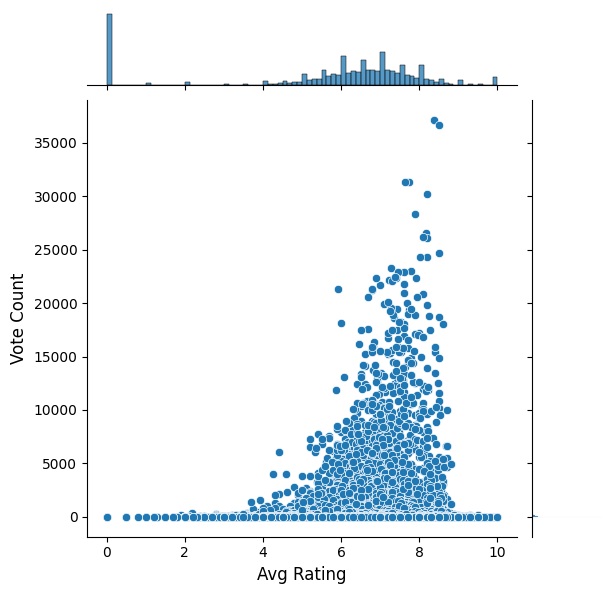

In [14]:
plt.figure(figsize = (13,7))
sns.jointplot(x = 'rating', y = 'vote_count', data = data)
plt.xlabel('Avg Rating', fontsize = 12)
plt.ylabel('Vote Count', fontsize = 12)
plt.show()

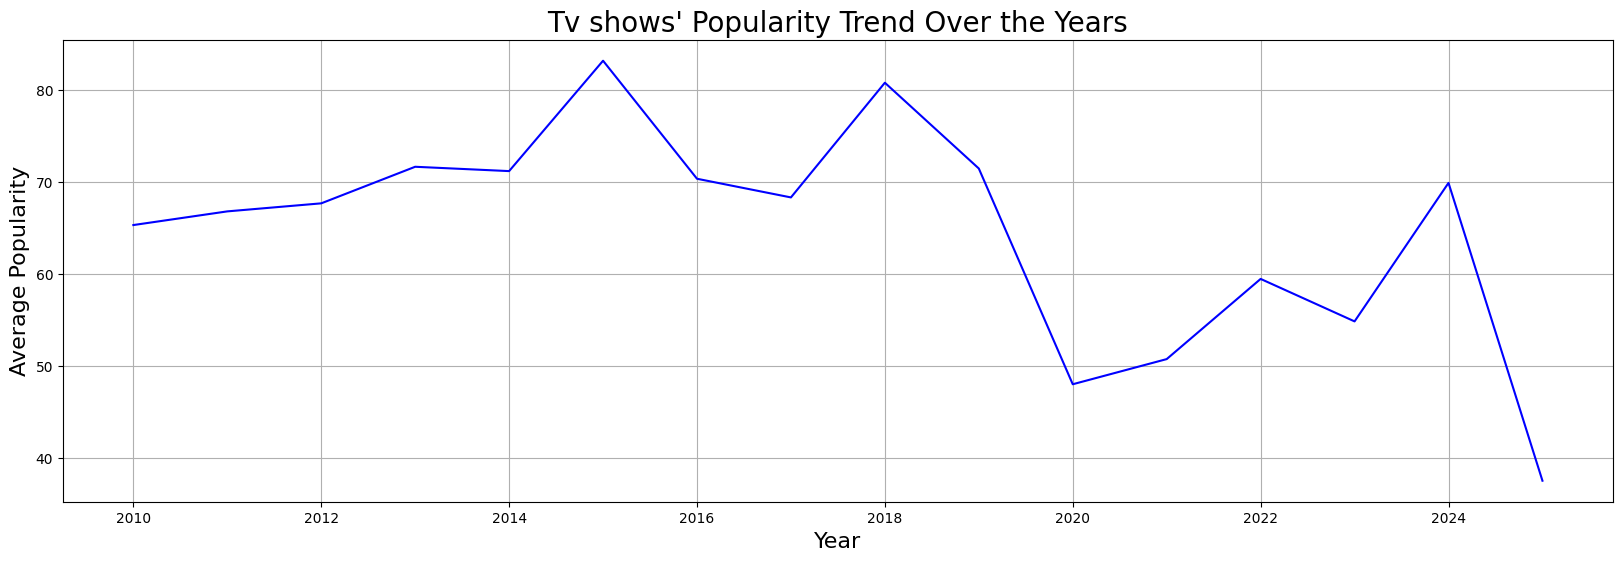

In [15]:
# Calculate the average popularity for each year
yearly_popularit = data2.groupby('release_year')['popularity'].mean()

plt.figure(figsize=(20, 6))
sns.lineplot(x=yearly_popularit.index, y=yearly_popularit.values, c = 'blue')
plt.title("Tv shows' Popularity Trend Over the Years", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Average Popularity', fontsize=16)
plt.grid(True)
plt.show()

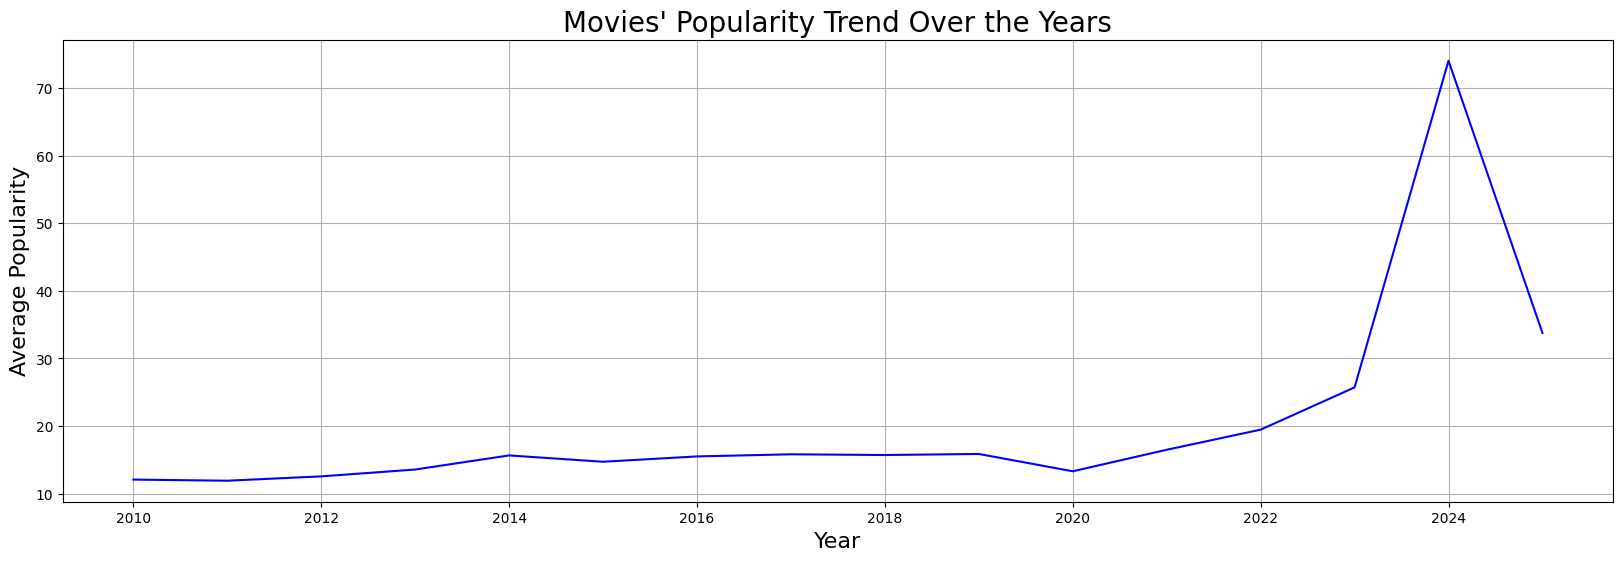

In [16]:
# Calculate the average popularity for each year
yearly_popular = data1.groupby('release_year')['popularity'].mean()

plt.figure(figsize=(20, 6))
sns.lineplot(x=yearly_popular.index, y=yearly_popular.values, c = 'blue')
plt.title("Movies' Popularity Trend Over the Years", fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Average Popularity', fontsize=16)
plt.grid(True)
plt.show()

In [17]:
data.head()

,show_id,type,title,director,cast,country,release_year,rating,genres,language,description,popularity,vote_count,vote_average,language_full
0,10192,Movie,Shrek Forever After,Mike Mitchell,"Mike Myers, Eddie Murphy, Cameron Diaz, Antoni...",United States of America,2010,6.380,"Comedy, Adventure, Fantasy, Animation, Family",en,A bored and domesticated Shrek pacts with deal...,203.893,7449,6.380,English
1,27205,Movie,Inception,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ken W...","United Kingdom, United States of America",2010,8.369,"Action, Science Fiction, Adventure",en,"Cobb, a skilled thief who commits corporate es...",156.242,37119,8.369,English
2,12444,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,"Daniel Radcliffe, Emma Watson, Rupert Grint, T...","United Kingdom, United States of America",2010,7.744,"Adventure, Fantasy",en,"Harry, Ron and Hermione walk away from their l...",121.191,19327,7.744,English
3,38757,Movie,Tangled,"Byron Howard, Nathan Greno","Mandy Moore, Zachary Levi, Donna Murphy, Ron P...",United States of America,2010,7.600,"Animation, Family, Adventure",en,"Feisty teenager Rapunzel, who has long and mag...",111.762,11638,7.600,English
4,10191,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois","Jay Baruchel, Gerard Butler, Craig Ferguson, A...",United States of America,2010,7.800,"Fantasy, Adventure, Animation, Family",en,As the son of a Viking leader on the cusp of m...,110.044,13259,7.800,English


## Hugging Face Transformer process

In [18]:
# Removing unnneccesary columns 
data_filter = data.drop(['language','cast','country', 'popularity', 'vote_count', 'vote_average', 'show_id'],axis = 1)

In [19]:
data_filter.head()

,type,title,director,release_year,rating,genres,description,language_full
0,Movie,Shrek Forever After,Mike Mitchell,2010,6.380,"Comedy, Adventure, Fantasy, Animation, Family",A bored and domesticated Shrek pacts with deal...,English
1,Movie,Inception,Christopher Nolan,2010,8.369,"Action, Science Fiction, Adventure","Cobb, a skilled thief who commits corporate es...",English
2,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,2010,7.744,"Adventure, Fantasy","Harry, Ron and Hermione walk away from their l...",English
3,Movie,Tangled,"Byron Howard, Nathan Greno",2010,7.600,"Animation, Family, Adventure","Feisty teenager Rapunzel, who has long and mag...",English
4,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois",2010,7.800,"Fantasy, Adventure, Animation, Family",As the son of a Viking leader on the cusp of m...,English


- ### Hugging face transformer system makes use of information, the more detialed the better to train its transformation model.
- ### For that reason, we will create a new column where we add the data we know from the dataset together to serve as our information.

In [20]:
# Fill NaNs with empty strings before combining
data_filter['title'] = data_filter['title'].fillna('')
data_filter['type'] = data_filter['type'].fillna('')
data_filter['language_full'] = data_filter['language_full'].fillna('')
data_filter['genres'] = data_filter['genres'].fillna('')
data_filter['description'] = data_filter['description'].fillna('')
data_filter['director'] = data_filter['director'].fillna('')


# Combine fields safely
data_filter['full_description'] = (
    data_filter['title'] + ' ' +
    data_filter['type'] + ' ' +
    data_filter['language_full'] + ' ' +
    data_filter['genres'] + ' ' +
    'plot: ' + data_filter['description'] + ' ' +
    'director: ' + data_filter['director']
)

In [21]:
data_filter.head()

,type,title,director,release_year,rating,genres,description,language_full,full_description
0,Movie,Shrek Forever After,Mike Mitchell,2010,6.380,"Comedy, Adventure, Fantasy, Animation, Family",A bored and domesticated Shrek pacts with deal...,English,"Shrek Forever After Movie English Comedy, Adve..."
1,Movie,Inception,Christopher Nolan,2010,8.369,"Action, Science Fiction, Adventure","Cobb, a skilled thief who commits corporate es...",English,"Inception Movie English Action, Science Fictio..."
2,Movie,Harry Potter and the Deathly Hallows: Part 1,David Yates,2010,7.744,"Adventure, Fantasy","Harry, Ron and Hermione walk away from their l...",English,Harry Potter and the Deathly Hallows: Part 1 M...
3,Movie,Tangled,"Byron Howard, Nathan Greno",2010,7.600,"Animation, Family, Adventure","Feisty teenager Rapunzel, who has long and mag...",English,"Tangled Movie English Animation, Family, Adven..."
4,Movie,How to Train Your Dragon,"Chris Sanders, Dean DeBlois",2010,7.800,"Fantasy, Adventure, Animation, Family",As the son of a Viking leader on the cusp of m...,English,How to Train Your Dragon Movie English Fantasy...


In [22]:
final_data = data_filter.drop(['genres','director', 'language_full'],axis = 1)

In [23]:
final_data.head()

,type,title,release_year,rating,description,full_description
0,Movie,Shrek Forever After,2010,6.380,A bored and domesticated Shrek pacts with deal...,"Shrek Forever After Movie English Comedy, Adve..."
1,Movie,Inception,2010,8.369,"Cobb, a skilled thief who commits corporate es...","Inception Movie English Action, Science Fictio..."
2,Movie,Harry Potter and the Deathly Hallows: Part 1,2010,7.744,"Harry, Ron and Hermione walk away from their l...",Harry Potter and the Deathly Hallows: Part 1 M...
3,Movie,Tangled,2010,7.600,"Feisty teenager Rapunzel, who has long and mag...","Tangled Movie English Animation, Family, Adven..."
4,Movie,How to Train Your Dragon,2010,7.800,As the son of a Viking leader on the cusp of m...,How to Train Your Dragon Movie English Fantasy...


- We would use Hugging Face Transformers to load an embedding model and transform the text into a numerical vector.
- Specifically, we would use sentence embedding to transform the whole sentence.
- It processes text into vector representations that capture **semantic meaning**

## To generate Sentence Embeddings

In [24]:
#!pip install sentence-transformers

In [25]:
#!pip install --user tf_keras

In [26]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              32000 non-null  object 
 1   title             32000 non-null  object 
 2   release_year      32000 non-null  int64  
 3   rating            32000 non-null  float64
 4   description       32000 non-null  object 
 5   full_description  32000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.5+ MB


In [27]:
# Display rows where 'full_description' is NaN
nan_rows = final_data[final_data['full_description'].isna()]
print(nan_rows)

Empty DataFrame
Columns: [type, title, release_year, rating, description, full_description]
Index: []


In [28]:
# To transform the whole 'full_description' column
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

embeddings = model.encode(final_data['full_description'].tolist())

- We would create a function to take user input and perform cosine similarity as a recommendation system.

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(query, embeddings, final_data, top_n):
    query_embedding = model.encode([query])
    similarities = cosine_similarity(query_embedding, embeddings)
    top_indices = similarities[0].argsort()[-top_n:][::-1]
    return final_data.iloc[top_indices]

In [30]:
# For simplicity
final_data = final_data.drop(['full_description'],axis = 1)

In [31]:
# Saving the final dataset
final_data.to_csv("final_data.csv", index=False, quoting=1)  # quoting=1 = csv.QUOTE_ALL

## Example 1

In [32]:
query = "Funny tv shows about highschool"
recommendations = get_recommendations(query, embeddings, final_data, top_n = 10)      # top_n= No of recommendations
recommendations

,type,title,release_year,rating,description
21687,TV Show,So Awkward,2015,7.300,"A sitcom about three very academically bright,..."
17010,TV Show,30 Vies,2011,6.200,Inspiring journey into a high school class – ...
24753,TV Show,The Cool Kids,2018,5.500,Three guy friends in a retirement community ar...
30364,TV Show,English Teacher,2024,6.441,A high school teacher in Austin tries to balan...
23510,TV Show,Mischievous Detectives,2017,2.800,A comedic mystery that follows two genius high...
6377,Movie,Good Kids,2016,6.300,Four high school students look to redefine the...
18262,TV Show,Daily Lives of High School Boys,2012,8.000,"Join Tadakuni, Hidenori and Yoshitake as they ..."
29684,TV Show,Class of '07,2023,6.800,When an apocalyptic tidal wave hits during the...
5165,Movie,Regular Show: The Movie,2015,7.800,After a high school lab experiment goes horrib...
24550,TV Show,The Teacher,2018,7.800,This series shows a school community's everyda...


## Example 2

In [33]:
query = "Horror movies"
recommendations_2 = get_recommendations(query, embeddings, final_data, top_n = 15)      # top_n= No of recommendations
recommendations_2

,type,title,release_year,rating,description
28841,TV Show,The 101 Scariest Horror Movie Moments of All Time,2022,6.800,"In this Shudder Original series, master filmma..."
5572,Movie,Tales of Halloween,2015,5.751,Ten stories from horror's top directors. Ghost...
15931,Movie,The Creeps: Noir Version,2025,0.000,Experience Charles Band's bizarre riff on clas...
11753,Movie,The Scary of Sixty-First,2021,5.600,Two roommates’ lives are upended after finding...
2276,Movie,American Horror House,2012,6.145,"On Halloween night, a sorority house is overru..."
9820,Movie,In Search of Darkness,2019,7.800,An exploration of '80s horror movies through t...
1959,Movie,Scream: The Inside Story,2011,6.100,"In 1996, the horror master Wes Craven unleashe..."
24512,TV Show,Eli Roth's History of Horror,2018,6.500,An in-depth look at the history and pop cultur...
8598,Movie,Nightmare Cinema,2018,5.900,A series of down-on-their-luck individuals ent...
9056,Movie,Haunt,2019,6.700,"On Halloween, a group of friends encounter an ..."


## Example 3

In [34]:
query = "Horror Tvshows"
recommendations_2 = get_recommendations(query, embeddings, final_data, top_n = 15)      # top_n= No of recommendations
recommendations_2

,type,title,release_year,rating,description
31617,TV Show,TerrorBytes: The Evolution of Horror Gaming,2025,0.000,TerrorBytes explores the rich history of horro...
27134,TV Show,American Horror Stories,2021,7.800,An anthology series of stand alone episodes de...
25441,TV Show,Dark/Web,2019,6.273,A horror anthology series that explores the da...
22782,TV Show,Channel Zero,2016,7.100,A horror anthology series inspired by “Creepyp...
17041,TV Show,American Horror Story,2011,8.100,An anthology horror drama series centering on ...
26227,TV Show,50 States of Fright,2020,7.200,A horror anthology series based on urban legen...
25201,TV Show,Creepshow,2019,7.500,A young boy's horror comic book comes to life ...
28841,TV Show,The 101 Scariest Horror Movie Moments of All Time,2022,6.800,"In this Shudder Original series, master filmma..."
24424,TV Show,The Terror,2018,7.352,A chilling anthology series featuring stories ...
17762,TV Show,Nightmare Next Door,2011,7.300,The tales of mysterious murders that rocked sm...


- #### To save the embeddings

In [35]:
 np.save('embeddings.npy', embeddings)